# Running analog Hamiltonian simulation with local simulator

We recommend to test and debug an analog Hamiltonian simulation (AHS) program on the local simulator before submitting it to a QPU. In this notebook, we introduce several features of the local simulator that will be useful to streamline this testing process.

To begin, we import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from ahs_utils import show_register, show_global_drive, plot_avg_density_2D, get_drive, get_avg_density

## 2D checkerboard phase 

In [this notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb), we considered an square grid of 9 atoms, and realized the 2D checkerboard phase via adiabatic evolution. Here we will consider an $5\times3$ grid of 15 atoms with exactly the same driving field, which is expected to realize the similar checkerboard phase.

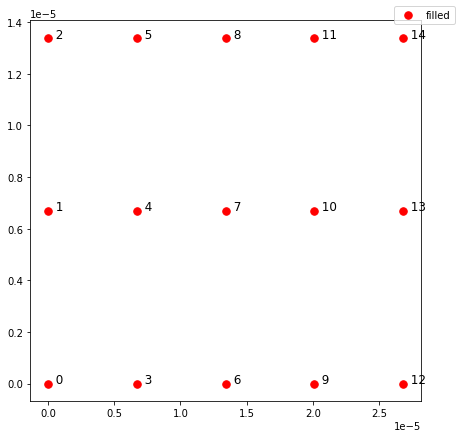

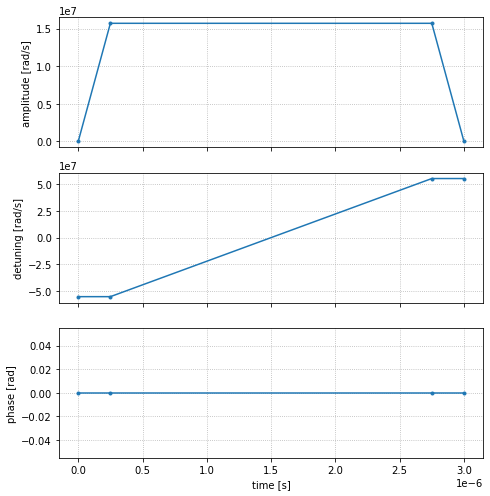

In [2]:
register = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(5):
    for l in range(3):
        register.add((k * separation, l * separation))


time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)    
    
    
show_register(register)
show_global_drive(drive);

The AHS program can be constructed by assembling the atomic register with the driving field.

In [3]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

We can then run the program on the local simulator as usual.

In [4]:
device = LocalSimulator("braket_ahs")

<div class="alert alert-block alert-info">
<b>Note: </b> The following cell will take around 15-40 minutes to complete, depending on the host machine used.
</div>


In [5]:
start_time = time.time()
result_full = device.run(ahs_program, shots=1000).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 1029.7143609523773 seconds


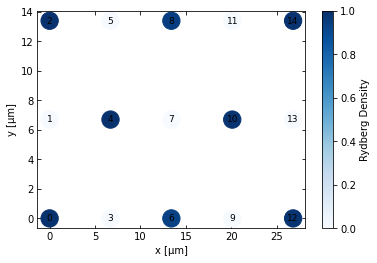

In [6]:
# show_final_avg_density(result_full)
plot_avg_density_2D(get_avg_density(result_full), register)

## Run AHS program in the blockade subspace

As we can see above, it takes a long time to finish the simulation because the *full* Hamiltonian is of size $2^{15}\times 2^{15}$. However, because of Rydberg blockade, if neighboring atoms are within each other's Rydberg blockade radius $R_b$, they are very unlikely to be excited to the Rydberg states simultaneously. Given that (see [notebook 00](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb))
\begin{align}
R_b = \left[\frac{C_6}{\sqrt{\Delta^2+\Omega^2}}\right]^{1/6},
\end{align}
we have $6.752~ \mu m<R_b<6.796~ \mu m$ throughout the program, which is always larger than $6.7~ \mu m$, the distances between neighboring atoms. Hence we can approximate the full Hamiltonian of the system with a smaller *effective* Hamiltonian. We can take advantage of this fact to speed up the simulation by setting the parameter `blockade_radius` as shown below.

In [17]:
start_time = time.time()
result_blockade = device.run(ahs_program, shots=1000, blockade_radius=6.796e-6).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 15.810049057006836 seconds


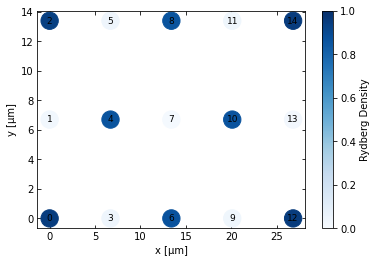

In [18]:
plot_avg_density_2D(get_avg_density(result_blockade), register)

In order to quantify the difference in the final average Rydberg densities from the two simulations, we can calculate the root-mean-square difference (RMS) defined as 
\begin{align}
\text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N(\bar{n}_i^\text{full}-\bar{n}_i^\text{blockade})^2}.
\end{align}
Here $\bar{n}_i^\text{full}$ and $\bar{n}_i^\text{blockade}$ are the final Rydberg density at the $i$-th site for the simulation with the full Hamiltonian and the effective Hamiltonian respectively.

In [9]:
n_full = get_avg_density(result_full)
n_blockade = get_avg_density(result_blockade)

RMS_blockade = np.sqrt(np.mean((np.array(n_full)-np.array(n_blockade))**2))
print(f"The RMS_blockade for the final Rydberg densities = {RMS_blockade}")

The RMS_blockade for the final Rydberg densities = 0.07154951665338721


Since the RMS is only around 7%, we are assured that the simulation with the effective Hamiltonian of smaller size gives quantitatively the same results as the one with the full Hamiltonian.

## Tuning other parameters in the local simulator

Another way to speed up the simulation, without using the blockade approximation, is to adjust other parameters of the local simulator, such as `rtol`, which is the relative error tolerance for solution. It is set to `1e-6` by default, but we can set it to `1e-2`, which tolerate a slightly larger error. We can also reset `order` to 2 for the solver. 

<div class="alert alert-block alert-info">
<b>Note: </b> The following cell will take around 10-30 minutes to complete, depending on the host machine used.
</div>


In [10]:
start_time = time.time()
result_reduced_nsteps = device.run(ahs_program, shots=1000, rtol=1e-2, order=2).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 978.1605520248413 seconds


We can confirm that the simulation produces result that is close to our expectation. 

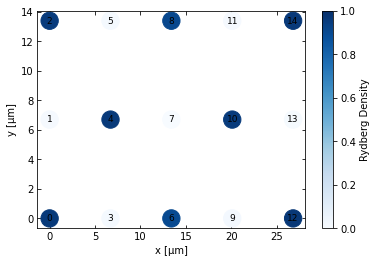

In [11]:
# show_final_avg_density(result_reduced_nsteps)
plot_avg_density_2D(get_avg_density(result_reduced_nsteps), register)

In [12]:
n_reduced_nsteps = get_avg_density(result_reduced_nsteps)

RMS_reduced_nsteps = np.sqrt(np.mean((np.array(n_full)-np.array(n_reduced_nsteps))**2))
print(f"The RMS_reduced_nsteps for the final Rydberg densities = {RMS_reduced_nsteps}")

The RMS_reduced_nsteps for the final Rydberg densities = 0.02286336224909481


We see that although the runtime is reduced compared to the simulation with default parameters, it is still much longer than the simulation performed in the reduced Hilbert space. The reason is that the local simulator will need to construct the Hilbert space in which the simulation is performed, and this takes majority part of the runtime. 

We also note that when the dimension of the Hilbert space is larger than 1000, the AHS local simulator use `scipy.integrate.ode` as the backend solver and support the following arguments: <code>atol</code>, <code>rtol</code>, <code>solver_method</code>, <code>order</code>, <code>nsteps</code>, <code>first_step</code>, <code>max_step</code> and <code>min_step</code>. For more information, please refer to the following <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html">documentation page</a>. 

When the dimension of the Hilbert space is less than or equal to 1000, we use a solver based on the <a href="https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_method">implicit Runge-Kutta method</a> written in `numpy`, which is more efficient than the `scipy.integrate.ode` solver in this case. The solver based on `numpy` does not support the arguments listed above.

For both solvers, one could also tune the argument `steps` to adjust the number of time points for the simulation, which is set to `100` by default. If the Hamiltonian is almost constant throughout the AHS program, simulation with smaller `steps`, such as 80 or 50, is likely sufficient to give qualitatively good result; On the other hand, if the Hamiltonian is varying drastically throughout the program, one may need to have higher `steps` around 200 or more.